In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [6]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

In [7]:
# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

100%|█████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [03:08<00:00, 52.7kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 48.1kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:14<00:00, 112kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.01MB/s]


In [8]:
# Get the shape of the first image in the training dataset
image, label = train_dataset[0]
print("Image shape:", image.shape)
print("Number of training samples:", len(train_dataset))

Image shape: torch.Size([1, 28, 28])
Number of training samples: 60000


In [9]:
# Get the shape of the first image in the test dataset
image, label = test_dataset[0]
print("Image shape:", image.shape)
print("Number of testing samples:", len(test_dataset))

Image shape: torch.Size([1, 28, 28])
Number of testing samples: 10000


In [10]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # write your code here
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # write your code here
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

In [12]:
from torchsummary import summary

# Initialize model
model = CNNClassifier()

# Move model to GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
    model.to(device)

# Print model summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
           Dropout-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated T

In [13]:
# Initialize model, loss function, and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
## Step 3: Train the Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_model(model, train_loader, num_epochs=3):
    model.train()

    # write your code here
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

train_model(model, train_loader, num_epochs=10)


Using device: cpu
Epoch [1/10], Loss: 0.2844
Epoch [2/10], Loss: 0.2819
Epoch [3/10], Loss: 0.2802
Epoch [4/10], Loss: 0.2782
Epoch [5/10], Loss: 0.2787
Epoch [6/10], Loss: 0.2815
Epoch [7/10], Loss: 0.2764
Epoch [8/10], Loss: 0.2735
Epoch [9/10], Loss: 0.2768
Epoch [10/10], Loss: 0.2759


In [18]:
## Step 4: Test the Model

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total

    print(f'Test Accuracy: {accuracy:.4f}')
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    # Print classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

Test Accuracy: 0.8988


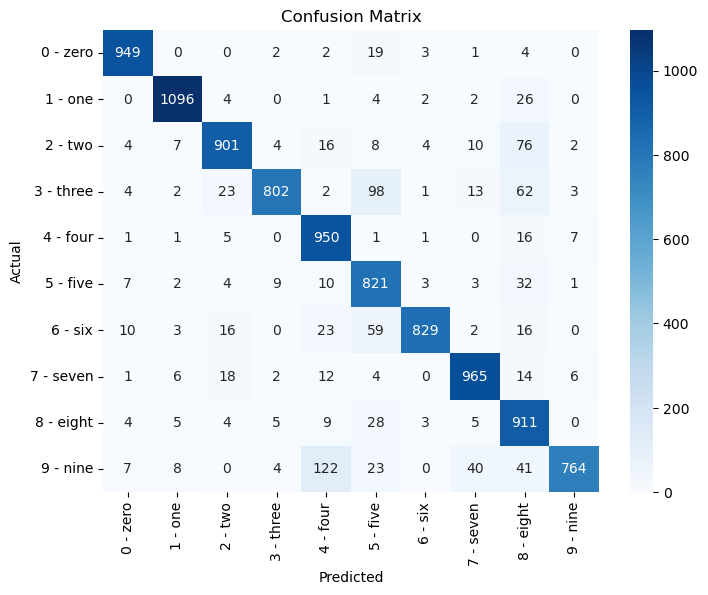

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.97      0.97      0.97      1135
           2       0.92      0.87      0.90      1032
           3       0.97      0.79      0.87      1010
           4       0.83      0.97      0.89       982
           5       0.77      0.92      0.84       892
           6       0.98      0.87      0.92       958
           7       0.93      0.94      0.93      1028
           8       0.76      0.94      0.84       974
           9       0.98      0.76      0.85      1009

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



In [19]:
# Evaluate the model
test_model(model, test_loader)

In [20]:
## Step 5: Predict on a Single Image
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    if torch.cuda.is_available():
        image = image.to(device)

    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output, 1)

    class_names = [str(i) for i in range(10)]

    plt.figure(figsize=(5, 5))
    plt.imshow(image.cpu().squeeze(), cmap="gray")
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()
    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted.item()]}')

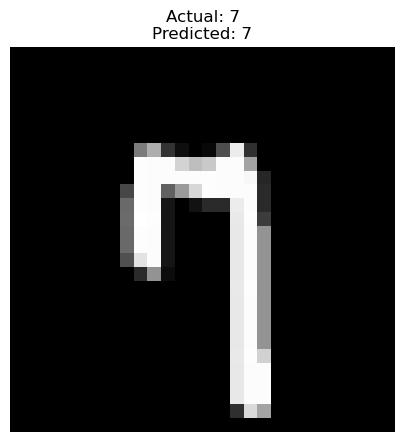

Actual: 7, Predicted: 7


In [21]:
# Example Prediction
predict_image(model, image_index=80, dataset=test_dataset)